# Ecosim - An Economics Simulator

The simulation imagines a world spread-out across a 2 dimensional surface. 
Across the surface, varying amounts of resources are available for collection by static agents. 
The agents harvest material and place it into storage.
Each tick, agents perform a series of actions - these are likely to include steps such as:
1. Collect
2. Synthesise
3. Trade
4. Consume
5. ...



## Stage 1 - Generating the environment

The environment is discrete - and has a finite size. 

Spread across the space are varying quantities of resource. The number of separate resources is defined by parameter r. Some resources are more commonly available than others, but the distribution of each resource is the result of some noisey function. A good candidate for a noise generating function might be Perlin noise, as provided by [Casey Duncan's noise](https://github.com/caseman/noise)

The topology is such that horizontal edges wrap so continually going east results in appearing in the westermost edge of the space. Topologically, the space is an open-ended cylinder.

To achieve the wrapping effect, first a 3-dimensional noise field is generated, and then this is sampled taking coordinates from the surface of an imagined cylinder. Unfolding that cylinder out into a 2d map returns the appropriate topological result, with smooth mappings from east to west edges. 

In [1]:
from noise import snoise2, snoise3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import sin, cos, pi
import random
from itertools import cycle

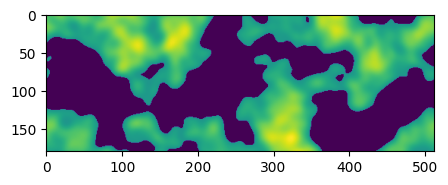

In [2]:
def wrap_perlin_horizontally(w,h,s,o):
    a = np.zeros((h,w))
    xs=random.random()*w
    ys=random.random()*h
    zs=random.random()*w
    for y in range(h):
        for x in range(w):
            r = (2*pi)/w
            a[y,x]=snoise3(((sin(x*r)*(w/(2*pi)))/(s))+xs, (y/(s))+ys, ((cos(x*r)*(w/(2*pi)))/(s))+zs, o)
    
    r = max(a.ravel()) - min(a.ravel())
    mi = min(a.ravel())
    
    a = a - mi
    a = a/r
    return a
a = wrap_perlin_horizontally(512,180,120,3)
fig=plt.figure(figsize=(5,5))
plt.imshow(np.where(a<0.52,0,a))

## Mapping from a torroidal topology

To further enhance the topology, a toroidal space might work better, resulting in effective wrapping at top and bottom edges in addition to the east-west wrapping effect.

$$  
\begin{align*}
x(\theta, \varphi) &= (R + r sin \theta) cos \varphi \\
y(\theta, \varphi) &= (R + r cos \theta) sin \varphi \\
z(\theta, \varphi) &= r sin \varphi \\
\end{align*}
$$

With R being the major radius, and r, the minor radius, and $\theta, \varphi$ (in range \[0,$2\pi$\) representing rotation about these two radii.

In [3]:
def cylinder_surface_parameter_to_xyz(ch, cr, theta, h):
    y = h
    x = cr * cos(theta)
    z = cr * sin(theta)
    return x, y, z

def torus_surface_parameter_to_xyz(R, r, theta, phi):
    x = (R + (r * sin(theta))) * cos(phi)
    y = (R + (r * cos(theta))) * sin(phi)
    z = r * sin(phi)
    return x,y,z

In [4]:
def wrap_perlin_torus(w,h,R,r,s,o):
    a = np.zeros((h,w))
    xs=random.random()*w
    ys=random.random()*h
    zs=random.random()*w
    for p in range(h):
        theta = ((2*pi)/h)*p
        for q in range(w):
            phi = ((2*pi)/w)*q
            x,y,z = [int(v) for v in torus_surface_parameter_to_xyz(R,r,theta,phi)]
            #print(x,y,z)
            a[p,q]=snoise3((x+xs)/s, (y+ys)/s, (z+zs)/s, o)
    
    r = max(a.ravel()) - min(a.ravel())
    mi = min(a.ravel())
    
    a = a - mi
    a = a/r
    return a

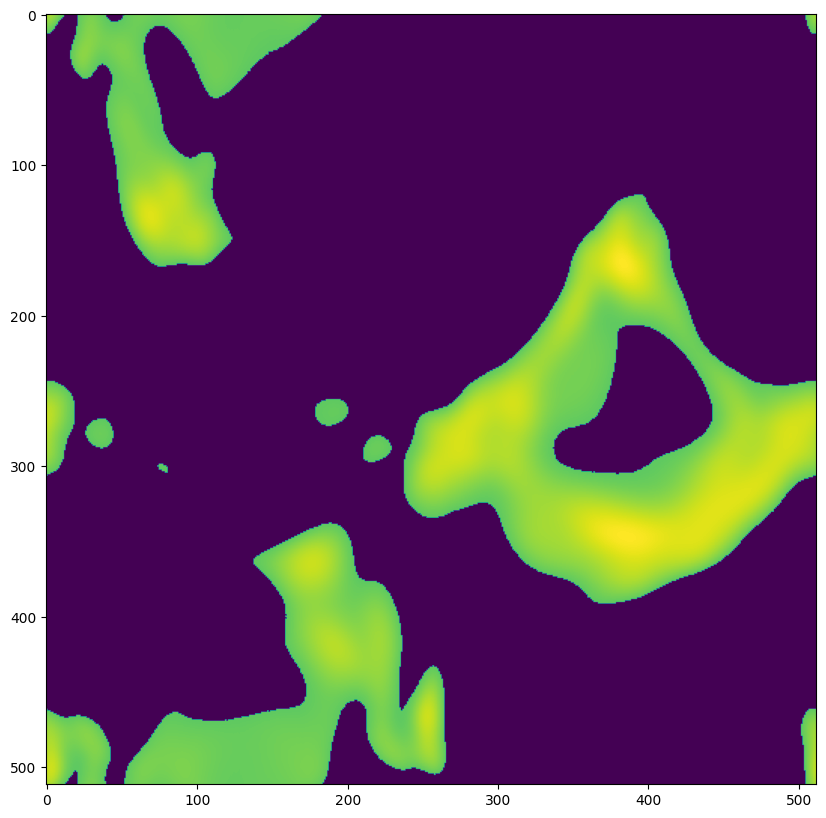

In [5]:
random.seed(101)
a = wrap_perlin_torus(512,512,200,600,1500,3)
fig=plt.figure(figsize=(10,10))
plt.imshow(np.where(a<0.75,0,a))

#plt.imshow(a)

In [6]:
perlin_specs = [[8,30,90,3, 0.55],
                [60,60,200,4, 0.35], 
                [160,260,80,4, 0.55],
                [160,260,800,4, 0.65],
                [16,8,20,2, 0.05]
               ]

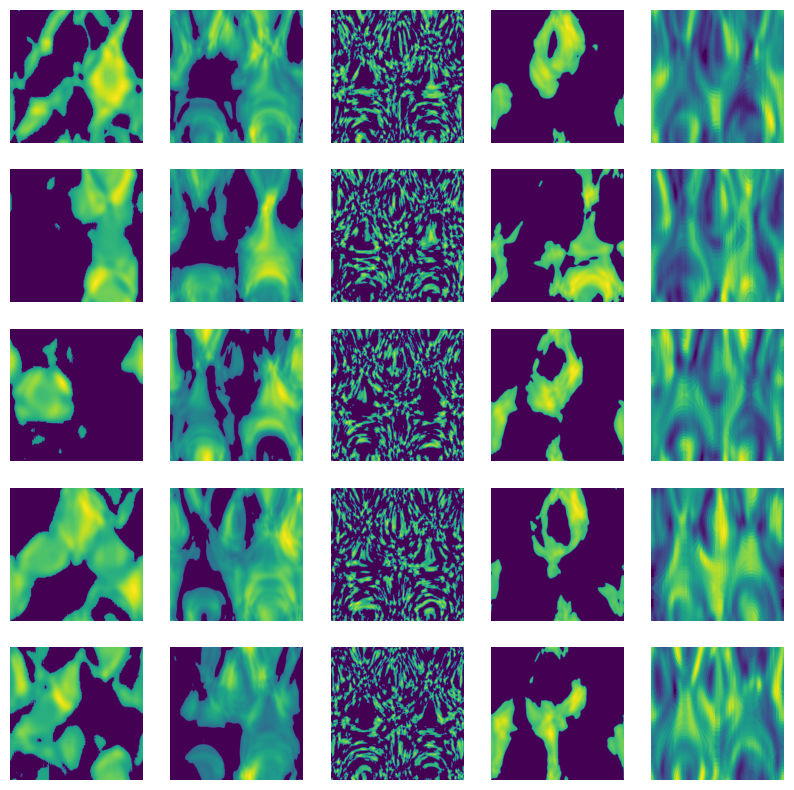

In [7]:
fig=plt.figure(figsize=(10,10))
gr=5
gc=len(perlin_specs)
gs = gridspec.GridSpec(gr,gc, figure=fig)
specs_cycle = cycle(perlin_specs)
random.seed()
for r in range(gr):
    for c in range(gc):
        spec = next(specs_cycle)
        ax = fig.add_subplot(gs[r,c])
        a = wrap_perlin_torus(512,512,spec[0],spec[1],spec[2],spec[3])
        ax.imshow(np.where(a<spec[4],0,a))
        #ax.imshow(a)
        ax.axis('off')
